Import the libraries

In [3]:
# Importing the libraries

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### Input to the model
Using image of rabbit as content image and splash of light as style image. You can use any other images as these two images. Here, train it for 10 iterations. Remember that we are not training any weights, but generating the candidate image using training. Therefore, not many iterations will be required. At the end of notebook, you will be able to see the results. 

In this notebook, 'candidate image' is referred as 'generated image'.

In [4]:
# loading the content image and style image

content_image_path = 'rabbit.jpg'
style_reference_image_path = 'style.jpg'

# prefix for saving the generated image 
result_prefix = 'gen'

# Number of iterations 
iterations = 10

# these are the weights of the different loss components
content_weight = 0.025
style_weight = 1.0

#### Defining the shape of the generated image. Let's make height as 400, and width according to the width:height ratio of the content image. 

In [6]:
# defining dimensions of the generated image
width, height = load_img(content_image_path).size

gen_height = 400

# Resizing width according to the height
gen_width = int( (width/ height) * gen_height)

print("Ratio of width is to height of content image is ", (width/height))
print("Ratio of width is to height of generated image is ", (gen_width/gen_height))

Ratio of width is to height of content image is  1.6
Ratio of width is to height of generated image is  1.6


#### Plot the content image and style image

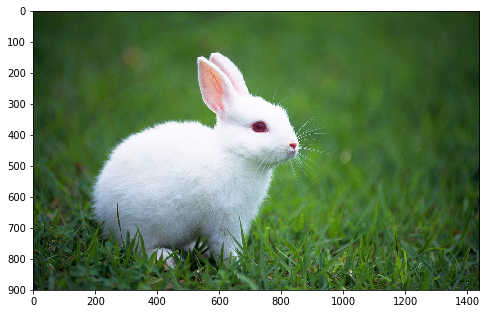

In [31]:
# Reading the content image
fig=plt.figure(figsize=(8, 8))
content_img = cv2.imread('rabbit.jpg')
plt.imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB))

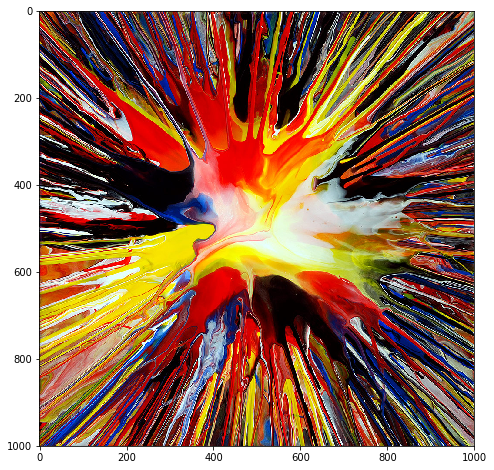

In [10]:
# Loading the style image
fig=plt.figure(figsize=(8, 8))
style_img = cv2.imread('style.jpg')
plt.imshow(cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB))

#### Preprocess the image. It will be used to preprocess the style and the content image, that we will give to the network. 

In [11]:
# preprocessing the image
# resizing the image to the size of generated image
# first we are expanding the dimension so as to include the batch size so it can be given to the network
# Then we are preprocessing the standard way of vgg19 as we are using its trained model
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(gen_height, gen_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

Once the candidate image is generated, we will plot it to see the result after deprocessing it using the following function.

In [12]:
def deprocess_image(x):
    x = x.reshape((gen_height, gen_width, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Note that, style transfer is different than training a CNN where we feed the input images during training process and the weights get updated in each iteration. Here, we are training the image itself. There is no native functionality in Keras to do style transfer. Therefore, we need to create a custom network where the image gets updated. Keras, however, does provide functionality to create customer networks by directly manipulating the tensorflow backend. You're already familiar with the steps involved in style transfer. In this notebook, you'll look at how to implement that in code. Before moving, there are certain tensorflow functions that you need to know about before proceeding. Till now, you didn't need to use these functions as these were taken care of by Keras. But you need to directly use these in order to create your custom network tailored according to the network.


### K.variable()
K.variable(), as the name suggest, can be used to store a variable. 


### K.placeholder()
With placeholders, we can insert values into the model in runtime. These can be used for training input(X) and target(Y) values.  The difference is that with <b>K.Variable() you have to provide an initial value when you declare it. With K.placeholder() we don't have to provide an initial value and can provide it at runtime.</b> 

Since, content and style image are contant and does not require to feed during runtime, we are using K.variable() to store that. Generated image is fed during runtime after each iteration, so we use placeholder for that. Note that when using backend as tensorflow(tf) for Keras, K.variable is same as tf.variable and K.placeholder is same as tf.placeholder. 

We combine the 3 images into a single Keras tensor along the axis of batch size(axis = 0) which we feed to the model. So the batch size will become 3. Along the dimension of batch size, the first is content image, second is style image and third the generated image get the content image feature

Additional reading: 
1. https://keras.io/backend/
2. https://learningtensorflow.com/lesson4/

In [13]:
# Get tensor representations of our images and store them in tensorflow variable
# These will go as input to the model
content_image = K.variable(preprocess_image(content_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# placeholder will contain our generated image
generated_image = K.placeholder((1, gen_height, gen_width, 3))

# combine the 3 images into a single Keras tensor along the axis of batch size(axis = 0)
# batch size = 3 (content_image,style_reference_image, generated_image)
input_tensor = K.concatenate([content_image,
                              style_reference_image,
                              generated_image], axis=0)

### Load VGG19 model 

In [14]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


### Giving name to the layers
We can give each layer a particular name while defining the model. <b> Later, you can access a particular layer with its name </b>. Let's look at the layers with their names. 

In [15]:
# Getting the model layers
print("Summary of the model", model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [16]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(" The output layers are ", outputs_dict)

 The output layers are  {'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 640, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 640, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 640, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 320, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 320, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 320, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 160, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 160, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 160, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 160, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 160, 256) dtype=float32>, 'blo

### Accessing layer by their name
We already know that we can access any layer by their name. We are using layer 'block5_conv2', which is fairly deep, for capturing the content of the image. 

### Capturing content 
We already know that deeper layers are able to capture most of the features of an image. And layer 'block5_conv2' is deep enough to capture the features. Also, <b>to capture more abstract features, we are using deeper VGG-19 instead of VGG-16</b>. Note that the content loss is calculated at only one layer which is generally one of the final layers. We'll calculate the content loss in the 'block5_conv2' layer. To calculate the style loss, we'll use multiple layers since style loss is calculated at multiple layers as you're already aware. 

#### Note that along the dimension of batch size, the first is content image, second is style image and third the generated image get the content image feature. We will seperate those to calculate the loss. 

In [17]:
# Selecting the layer  for content loss
layer_features = outputs_dict['block5_conv2']

# Along the dimension of batch size, the first is content image, second is style image and third the generated image
# get the content image feature 
content_image_features = layer_features[0, :, :, :]
print("Shape of content_image_featues is ", content_image_features.shape )

# get the generated image feature
generated_features = layer_features[2, :, :, :]
print("Shape of generated_features is ", generated_features.shape )

Shape of content_image_featues is  (25, 40, 512)
Shape of generated_features is  (25, 40, 512)


Let's understand the dimension of (25, 47, 512). It denotes <b>512 feature vector, each of height 25 and width 47</b>. Let's see the width/height ratio: 49/25=1.96. This is almost equal to 1.90, which is the width/height ratio of the original image. This shows that both width and height are reduced by same factor during convolution and pooling operation

## Loss Function
Now we will define the loss functions for the style loss and the content loss. For the style loss, we will define the Gram matrix.

### Define Gram matrix
How do you capture relationship between 2 vector? By correlation! Correlation is a statistical measure that captures the relationship between 2 varibles. Correlation indicates the extent to which change in one variable increase or decrease the other variable.


We may see an image as distribution over different feature vectors. Each feature vector in a layer captures some aspect of image. For example, in the initial layer, feature vectors captures edges. Gram matrix captures correlation between different feature vectors, not the presence or absence of specific features. Gram matrix is the product between a matrix and its transpose.

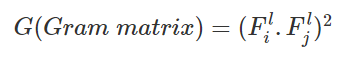


In [18]:
# compute the neural style loss
# the gram matrix of an image tensor (feature-wise outer product)
# In the output of size (25, 47, 512) there are 512 feature vectors, each of size 25 x 47

def gram_matrix(x):
    # Since the features are along the 3rd axis, we permute them to bring them to the first axis.
    # The tensor will become a tensor of size (512, 25, 47)
    # Then we flatten the tensor. It becomes (512, 1175)
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    
    # We take dot product with itself - (512 x 1175  x  1175 x 512) - which results in (512 x 512) matrix
    gram = K.dot(features, K.transpose(features))
    return gram

### Define Style Loss
The style loss is sum of L2 distances between the Gram matrices of the representations of the generated image and the style image, extracted from different layers of CNN(here, VGGNet). The general idea is to capture style (color/texture/shapes/edges etc) at different layers.

Let $A^l$ and $G^l$ style representations of generated(artistic) and style image in layer $l$. The contribution of that layer to the total loss is:
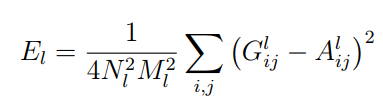

and the total style loss is:
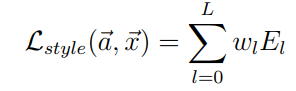

In [19]:
def style_loss(style, generation):
    
    '''
    Input: 
    style      -  the style feature vector that we get using the VGG19
    generation -  the generated feature vector that we get using the VGG19
    
    Returns: style loss
    '''
    
    assert K.ndim(style) == 3
    assert K.ndim(generation) == 3
    
    S = gram_matrix(style)
    C = gram_matrix(generation)
    
    channels = 3
    size = gen_width * gen_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


### Define Content Loss
The content loss is a L2 distance between the features of the generated image and the features of the content image. Let $P^l$ and $F^l$ be feature representation of content image and generated image in layer $l$. We then define the squared-error loss between the two feature representations as:

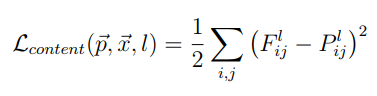

In [20]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(content, generation):
    
    '''
    Input: 
    content    -  the content feature vector that we get using the VGG19
    generation -  the generated feature vector that we get using the VGG19
    
    Returns: content loss
    '''
    return K.sum(K.square(generation - content))

## Total Loss

Now we will combine style loss and content loss to find total loss. Let's define variable to store the the loss.

### Calculate Content Loss
Calculate content loss by multiplying content loss with its weight

In [21]:
# make variable to store total loss and initialise it with '0.'
loss = K.variable(0.)

# calculating the content loss by multiplying content loss with its weight
loss += content_weight * content_loss(content_image_features,
                                      generated_features)


### Calculate Style Loss and add to Content Loss
Here, we will calculate style loss for a particular set of layers and add the style loss calculated at each of these layers to the content loss to find the total loss. 
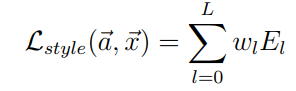

In [22]:
# defining the layers for which we want to calculate style loss
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

# calculating the style loss for all the feature layers
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    
    # style feature is the second layer along the batch dimension and generated features is along the third 
    style_reference_features = layer_features[1, :, :, :]
    generated_features = layer_features[2, :, :, :]
    
    # calculating the style loss for each feature layer 
    sl = style_loss(style_reference_features, generated_features)
    
    # add the style loss to previous loss to calculate total loss
    loss += (style_weight / len(feature_layers)) * sl

### Calculate gradient 
#### Calculate gradient of loss with respect to the pixels of the generated image. Here, we do not change the pre-trained weights of the VGG19. We use the pre-trained weights just to capture the different style and content aspect of the images and then we calculate the loss. 

### Output of the model
We will use scipy-based optimization (L-BFGS) over the pixels of the generated image as loss function(instead of SGD or other loss function). The L-BFGS optimiser takes two parameters: the loss and the gradient of the image w.r.t. the loss. To generate the gradient and the loss, we'll use Keras' k.function().

### K.function()
We need to define a function, which takes in the generated image, spits out the loss and the gradient. The output of the function will be used for optimisation. Till now, Keras used to do all this for you in the beacked. But in this problem, you need . In Keras, we define such a custom function (with a custom input and custom output), using K.function().

Additional reading: https://keras.io/getting-started/faq/

In [23]:
# get the gradients of the generated image w.r.t. the loss
grads = K.gradients(loss, generated_image)

# get the loss and gradient in the output variable
outputs = [loss]

# add gradient to the output
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
    
# K.function(inputs, outputs, updates=None), like how we make model, where
# inputs: List of placeholder tensors, here it is generated_image which we have defined above
# outputs: List of output tensors, here it is loss with which we want to update the inputs
# returns outputs(loss here) after evaluating inputs(generated image) on model
# https://keras.io/getting-started/faq/

f_outputs = K.function([generated_image], outputs)

## Define a function to feed the generated image and get the output - loss and gradient.
We define function, that takes input as generated image, and return combined loss and grad values using the function f_outputs that we have defined above. 

In [24]:
def eval_loss_and_grads(x):
    
    '''
    x : x is the generated image on which we do iteration. So, here we feed generated image to the model which
        we have defined using K.function(input, output). It will return output(outs) which is combination of loss and grad.
        We segregate the loss value and grad value.
    
    Returns: loss_value, grad_values
    
    '''
    
    x = x.reshape((1, gen_height, gen_width, 3))
    
    # here we feed generated input to the model to calulate the output
    outs = f_outputs([x])
    
    # Rembember the first value of outs is loss value and the second value is gradient
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### Define Class Evaluator
In the above function 'eval_loss_and_grads', it returned the combined loss and grad value. Here, we define a class which has separate 'loss' function and 'grads' function, that will seperate the loss and grad values. They will return those values separately.

In [25]:
class Evaluator(object):
    
    '''
    Input: Input to the fucntion is generated image. Here to pass it to eval_loss_and_grads function
           to calculate the loss and grad on it. 
    
    Return: loss function will return loss value 
            grad fucntion will return grad value
    '''

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    # Return loss value     
    def loss(self, x):
        assert self.loss_value is None
        # call the eval_loss_and_grads function, using input as generated image
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        # Return loss value
        return self.loss_value

    # Return grad values
    def grads(self, x):
        assert self.loss_value is not None
        # Make copy of grad value
        grad_values = np.copy(self.grad_values)
        # set the loss value and grad values none for next iteration
        self.loss_value = None
        self.grad_values = None
        # Return grad value for current iteration
        return grad_values

In [26]:
# Initialize the class
evaluator = Evaluator()

## Train the model
We will use the L-BFGS optimiser to update the generated image. L-BFGS has empirically shown to be much more suitable for this task.

### Steps:
#### 1. Initialize the generated image with content image (rather than initialising it with white noise)
#### 2. Pass the image along with grad and loss values to the optimiser 'fmin_l_bfgs_b()'. The optimiser will return the updated image. 
#### 3. Deprocess the image and save it.
#### 4. Repeat steps 3 and 4 for a fix number of iterations.

In [27]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# Initialize the generated image with content image (x) and pass to  fmin_l_bfgs_b()
x = preprocess_image(content_image_path)
iterations = 10
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    
    # optimizing the neural style loss
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    cv2.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 16592554000.0
Image saved as gen_at_iteration_0.png
Iteration 0 completed in 905s
Start of iteration 1
Current loss value: 5359437000.0
Image saved as gen_at_iteration_1.png
Iteration 1 completed in 720s
Start of iteration 2
Current loss value: 3033724200.0
Image saved as gen_at_iteration_2.png
Iteration 2 completed in 839s
Start of iteration 3
Current loss value: 2141884200.0
Image saved as gen_at_iteration_3.png
Iteration 3 completed in 812s
Start of iteration 4
Current loss value: 1572994300.0
Image saved as gen_at_iteration_4.png
Iteration 4 completed in 780s
Start of iteration 5
Current loss value: 1290997900.0
Image saved as gen_at_iteration_5.png
Iteration 5 completed in 806s
Start of iteration 6
Current loss value: 1100186000.0
Image saved as gen_at_iteration_6.png
Iteration 6 completed in 818s
Start of iteration 7
Current loss value: 952131650.0
Image saved as gen_at_iteration_7.png
Iteration 7 completed in 806s
Start of iteration 8
Cur

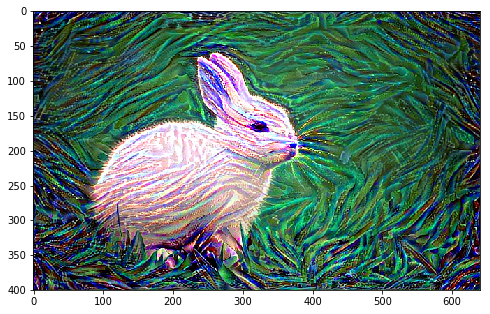

In [28]:
# Generated imaage at first iteration
fig=plt.figure(figsize=(8, 8))
gen_image_final = cv2.imread('gen_at_iteration_1.png')    
plt.imshow(cv2.cvtColor(gen_image_final, cv2.COLOR_BGR2RGB))

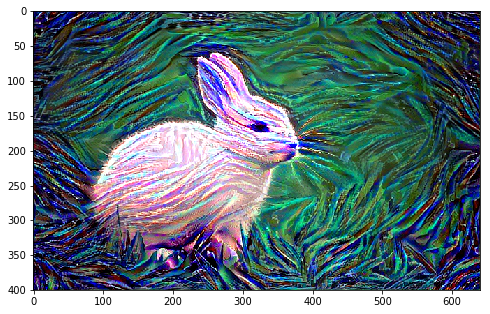

In [29]:
# Generated imaage at fifth iteration
fig=plt.figure(figsize=(8, 8))
gen_image_final = cv2.imread('gen_at_iteration_5.png')    
plt.imshow(cv2.cvtColor(gen_image_final, cv2.COLOR_BGR2RGB))

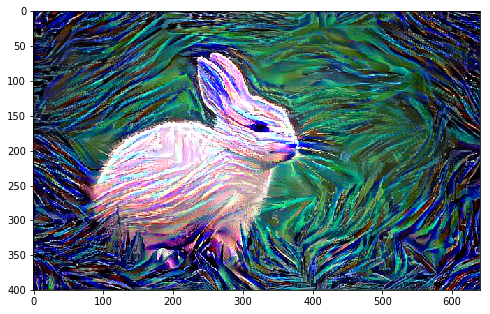

In [30]:
# Generated imaage at 9th iteration
fig=plt.figure(figsize=(8, 8))
gen_image_final = cv2.imread('gen_at_iteration_9.png')    
plt.imshow(cv2.cvtColor(gen_image_final, cv2.COLOR_BGR2RGB))